## Import packages


In [2]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# data munging tools
import pandas as pd
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## Reading in the data

In [4]:
filename = os.path.join("..", "data", "fake_or_real_news.csv")

DATA = pd.read_csv(filename, index_col=0)

__Inspect data__

In [5]:
DATA.sample(10)

,title,text,label
3294,Mitch McConnell Pledges To Avoid Debt Ceiling ...,WASHINGTON -- Senate Majority Leader Mitch McC...,REAL
4655,Conway touts Trump's 'drain the swamp' message...,"""We are behind. She has some advantages,"" Kell...",REAL
6749,Josh Fox on Dakota Access Pipeline Standoff: ‘...,Josh Fox on Dakota Access Pipeline Standoff: ‘...,FAKE
2834,Iraq launches operation against ISIS in Anbar ...,The Iraqi government -- supported by Shiite mi...,REAL
7953,Retired Bishop Explains Why The Catholic Churc...,"Without a doubt, religion is one of the more d...",FAKE
3177,"Fireworks erupt between Trump and Bush, Rubio ...",Sparks flew at the toughest and liveliest GOP ...,REAL
1696,Donald Trump attacks force Jeb Bush out of his...,(CNN) The aggressive Jeb Bush that his allies ...,REAL
1551,Why Putin praised Trump (Opinion),Christian Whiton is a former deputy special en...,REAL
10523,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,FAKE
1442,Donald Trump could 'shoot somebody and not los...,"""I could stand in the middle of 5th Avenue and...",REAL


In [6]:
DATA.shape

(6335, 3)

<br>
Q: How many examples of each label do we have?

In [7]:
DATA["label"].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

## Create balanced data

We can use the function ```balance``` to create a more even dataset.

In [9]:
DATA_balanced = clf.balance(DATA, 1000)

In [10]:
DATA_balanced.shape

(2000, 3)

<br>

What do the label counts look like now?

In [11]:
DATA_balanced["label"].value_counts()

FAKE    1000
REAL    1000
Name: label, dtype: int64

<br>

Let's now create new variables called ```texts``` and ```lables```, taking the data out of the dataframe so that we can mess around with them.

In [12]:
texts = DATA_balanced["text"]
labels = DATA_balanced["label"]

# Train-test split

I've included most of the 'hard work' for you here already, because these are long cells which might be easy to mess up while live-coding.

Instead, we'll discuss what's happening. If you have questions, don't be shy!

In [13]:
X_train, X_test, y_train, y_test = train_test_split(texts,           # texts for the model
                                                    labels,          # classification labels
                                                    test_size=0.2,   # create an 80/20 split
                                                    random_state=42) # random state for reproducibility

# Vectorizing and Feature Extraction

Vectorization. What is it and why are all the cool kids talking about it?

Essentially, vectorization is the process whereby textual or visual data is 'transformed' into some kind of numerical representation. One of the easiest ways to do this is to simple count how often individual features appear in a document.

Take the following text: 
<br><br>
<i>My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip. So, I called myself Pip, and came to be called Pip.</i>
<br>

We can convert this into the following vector

| and | be | being | both | called | came | christian | could | explicit | family | father | i | infant | longer | make | more | my | myself | name | names | nothing | of | or | philip | pip | pirrip | s | so | than | to | tongue|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |  --- |
| 2 | 1 | 1 | 1 | 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 2 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 | 1 | 1 |

<br>
Our textual data is hence reduced to a jumbled-up 'vector' of numbers, known somewhat quaintly as a <i>bag-of-words</i>.
<br>
<br>
To do this in practice, we first need to create a vectorizer. 

Tfidf vectors tend to be better for training classifiers. Why might that be?

__Create vectorizer object__

In [14]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),     # unigrams and bigrams (1 word and 2 word units)
                                                      # ngrams: tokens that appear together in the data
                                                      # find every possible combinations of uni and bigrams
                             lowercase =  True,       # why use lowercase?
                             max_df = 0.95,           # remove very common words (in more than 95% of docs - remove)
                             min_df = 0.05,           # remove very rare words (in less than 5% of the docs - remove)
                             max_features = 500)      # keep only top 500 features

This vectorizer is then used to turn all of our documents into a vector of numbers, instead of text.

In [15]:
# First we do it for our training data...
# Taking dataset + vectoriser, fitting and transforming, set of feature for the training data
X_train_feats = vectorizer.fit_transform(X_train)
#... then we do it for our test data
# set of features for the test data
X_test_feats = vectorizer.transform(X_test)
# We can also create a list of the feature names. 
# unigrams and bigrams the vectoriser has extracted from the data 
feature_names = vectorizer.get_feature_names()

<br>
Q: What are the first 20 features that are picked out by the CountVectorizer?

In [21]:
feature_names[:10]

['000',
 '10',
 '11',
 '2016',
 'about',
 'about the',
 'according',
 'according to',
 'across',
 'act']

## Classifying and predicting

We now have to 'fit' the classifier to our data. This means that the classifier takes our data and finds correlations between features and labels.

These correlations are then the *model* that the classifier learns about our data. This model can then be used to predict the label for new, unseen data.

In [25]:
classifier = LogisticRegression(random_state=42).fit(X_train_feats, y_train)

Q: How do we use the classifier to make predictions?

In [26]:
y_pred = classifier.predict(X_test_feats)

Q: What are the predictions for the first 20 examples of the test data?

In [28]:
print(y_pred[0:20])

['REAL' 'FAKE' 'REAL' 'REAL' 'REAL' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'FAKE'
 'FAKE' 'REAL' 'REAL' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'REAL']


We can also inspect the model, in order to see which features are most informative when trying to predict a label. 

To do this, we can use the ```show_features``` function that I defined earlier - how convenient!

Q: What are the most informative features? Use ```show_features```to find out!

In [29]:
clf.show_features(vectorizer, y_train, classifier, n=20)

FAKE				REAL

-3.0028	hillary        		2.4555	candidates     
-2.7079	by             		2.1282	obama          
-2.5798	october        		1.9688	cruz           
-2.0649	russia         		1.9556	but            
-1.8576	election       		1.9427	percent        
-1.7010	you            		1.8979	republican     
-1.6763	of             		1.8918	sanders        
-1.6574	us             		1.8248	house          
-1.5915	november       		1.7683	debate         
-1.5807	com            		1.7133	in             
-1.5546	your           		1.6456	president      
-1.4203	the us         		1.6308	white          
-1.4138	fbi            		1.5475	republicans    
-1.3796	email          		1.5442	conservative   
-1.1788	world          		1.5191	administration 
-1.1041	russian        		1.5127	iran           
-1.0744	war            		1.4950	that           
-1.0611	see            		1.4482	among          
-1.0591	hillary clinton		1.4402	who            


## Evaluate

The computer has now learned a model of how our data behaves. Well done, computer! But is it accurate?

Q: How do we measure accuracy?

<img src="../img/confusionMatrix.jpg">

Thankfully, libraries like ```sklearn``` come with a range of tools that are useful for evaluating models.

One way to do this, is to use a confusion matrix, similar to what you see above.

Q: What should go in the argument called ```labels```?

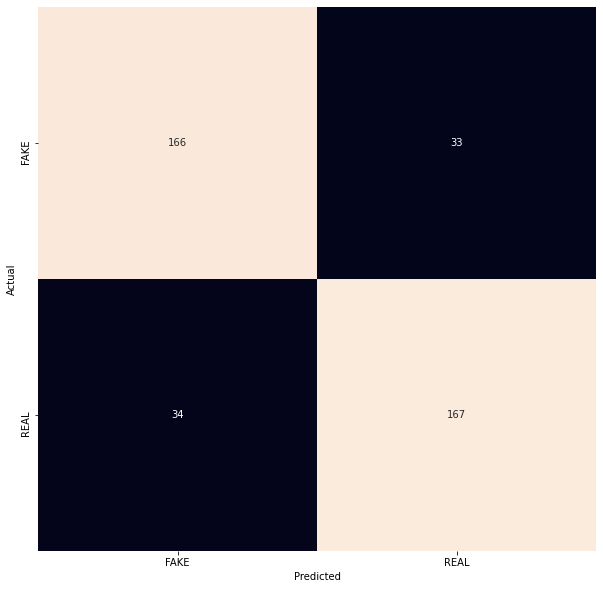

In [30]:
clf.plot_cm(y_test, y_pred, normalized=False)

We can also do some quick calculations, in order to assess just how well our model performs.

In [31]:
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

        FAKE       0.83      0.83      0.83       199
        REAL       0.83      0.83      0.83       201

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



## Cross validation and further evaluation

One thing we can't be sure of is that our model performance is simply related to how the train-test split is made.

To try to mitigate this, we can perform cross-validation, in order to test a number of different train-test splits and finding the average scores.

Let's do this on the full dataset

In [32]:
X_vect = vectorizer.fit_transform(texts)

The first plot is probably the most interesting. Some terminology:

- If two curves are "close to each other" and both of them but have a low score, the model suffers from an underfitting problem (High Bias)

- If there are large gaps between two curves, then the model suffer from an overfitting problem (High Variance)


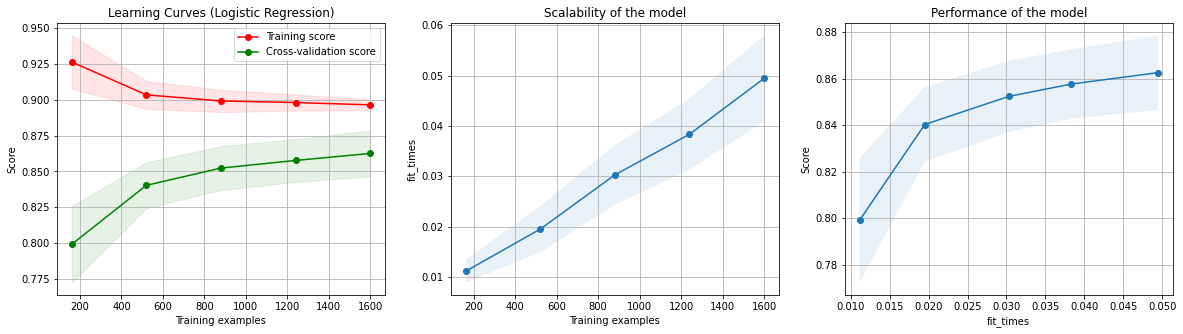

In [33]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(random_state=42)
clf.plot_learning_curve(estimator, title, X_vect, labels, cv=cv, n_jobs=4)

- The second plot shows the times required by the models to train with various sizes of training dataset. 
- The third plot show how much time was required to train the models for each training sizes.